[*********************100%%**********************]  1 of 1 completed


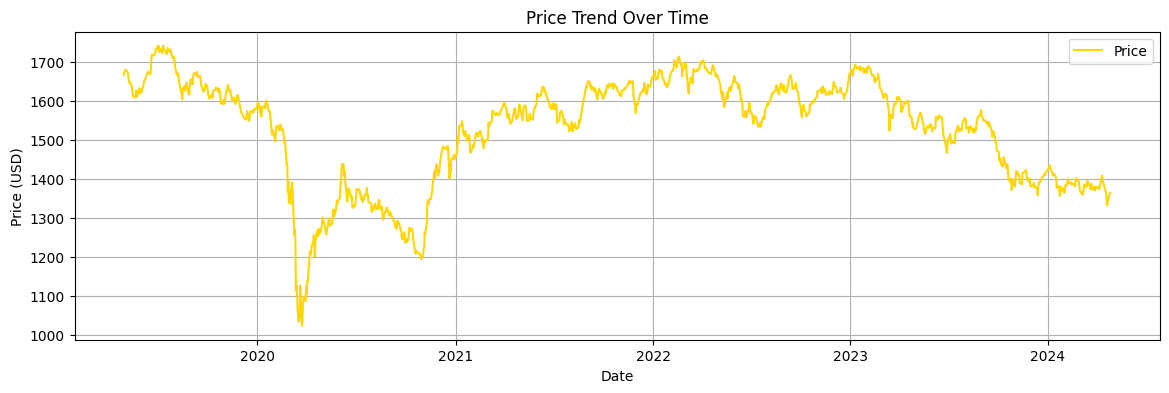

In [3]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

# sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')

# symbols_list = sp500['Symbol'].unique().tolist()


# df = yf.download(tickers = symbols_list, start = start_date, end = end_date).stack()

end_date = '2024-04-26'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*5)

tickers = "^SET.BK"
data = yf.download(tickers, start = start_date, end = end_date)
# Plotting
plt.figure(figsize=(14, 4))
plt.plot(data['Close'], label='Price', color='gold')
plt.title('Price Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
import pandas as pd
# Preprocess data
dataset_ex_df = data.copy()
dataset_ex_df = dataset_ex_df.reset_index()
dataset_ex_df['Date'] = pd.to_datetime(dataset_ex_df['Date'])
dataset_ex_df.set_index('Date', inplace=True)
dataset_ex_df = dataset_ex_df['Close'].to_frame()

In [5]:
from pmdarima.arima import auto_arima

model = auto_arima(dataset_ex_df['Close'], seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9877.030, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9883.147, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9884.355, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9884.413, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9881.503, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9888.412, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9880.951, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=9881.276, Time=0.47 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9884.425, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=9881.621, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=9881.896, Time=0.26 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=9882.572, Time=0.73 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=9875.329, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

In [6]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Define the ARIMA model
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()
    
    # Make the prediction
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

# Split data into train and test sets
X = dataset_ex_df.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

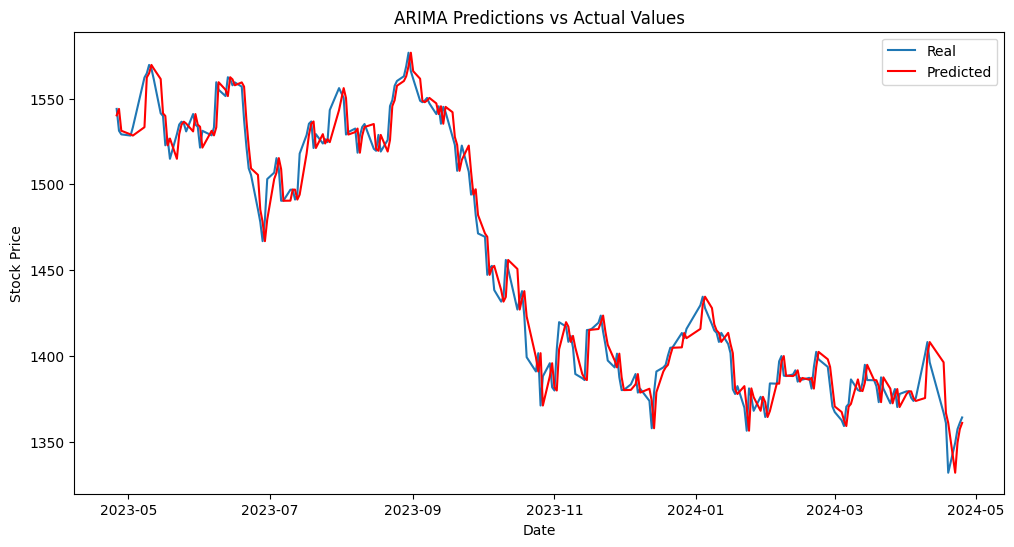

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(dataset_ex_df.iloc[size:,:].index, test, label='Real')
plt.plot(dataset_ex_df.iloc[size:,:].index, predictions, color='red', label='Predicted')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

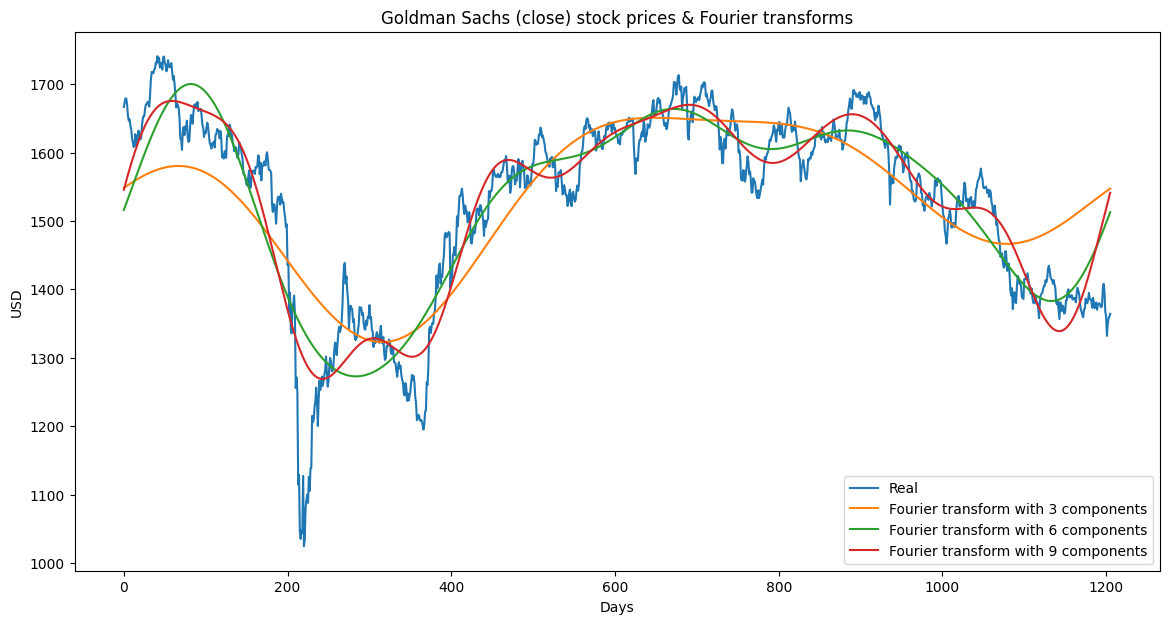

In [8]:
# Calculate the Fourier Transform
data_FT = dataset_ex_df[['Close']]
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

# Plot the Fourier Transforms
plt.figure(figsize=(14, 7), dpi=100)
plt.plot(np.asarray(data_FT['Close'].tolist()),  label='Real')
for num_ in [3, 6, 9]:
    fft_list_m10= np.copy(close_fft); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [9]:
# Calculate EMA
def ema(close, period=20):
    return close.ewm(span=period, adjust=False).mean()

# Calculate RSI
def rsi(close, period=14):
    delta = close.diff()
    gain, loss = delta.copy(), delta.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    avg_gain = gain.rolling(period).mean()
    avg_loss = abs(loss.rolling(period).mean())
    rs = avg_gain / avg_loss
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

# Calculate MACD
def macd(close, fast_period=12, slow_period=26, signal_period=9):
    fast_ema = close.ewm(span=fast_period, adjust=False).mean()
    slow_ema = close.ewm(span=slow_period, adjust=False).mean()
    macd_line = fast_ema - slow_ema
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    histogram = macd_line - signal_line
    return macd_line

# Calculate OBV
def obv(close, volume):
    obv = np.where(close > close.shift(), volume, np.where(close < close.shift(), -volume, 0)).cumsum()
    return obv

In [10]:
# Add technical indicators to dataset DF
dataset_ex_df['ema_20'] = ema(data["Close"], 20)
dataset_ex_df['ema_50'] = ema(data["Close"], 50)
dataset_ex_df['ema_100'] = ema(data["Close"], 100)

dataset_ex_df['rsi'] = rsi(data["Close"])
dataset_ex_df['macd'] = macd(data["Close"])
dataset_ex_df['obv'] = obv(data["Close"], data["Volume"])

# Create arima DF using predictions
arima_df = pd.DataFrame(history, index=dataset_ex_df.index, columns=['ARIMA'])

# Set Fourier Transforms DF
fft_df.reset_index(inplace=True)
fft_df['index'] = pd.to_datetime(dataset_ex_df.index)
fft_df.set_index('index', inplace=True)
fft_df_real = pd.DataFrame(np.real(fft_df['fft']), index=fft_df.index, columns=['Fourier_real'])
fft_df_imag = pd.DataFrame(np.imag(fft_df['fft']), index=fft_df.index, columns=['Fourier_imag'])

# Technical Indicators DF
technical_indicators_df = dataset_ex_df[['ema_20', 'ema_50', 'ema_100', 'rsi', 'macd', 'obv', 'Close']]

# Merge DF
merged_df = pd.concat([arima_df, fft_df_real, fft_df_imag, technical_indicators_df], axis=1)
merged_df = merged_df.dropna()
merged_df

,ARIMA,Fourier_real,Fourier_imag,ema_20,ema_50,ema_100,rsi,macd,obv,Close
2019-05-22,1626.910034,998.871523,-7171.086531,1642.481620,1655.093975,1660.523839,31.263515,-13.391297,-53691800,1626.910034
2019-05-23,1609.790039,3691.782291,-12194.492520,1639.368136,1653.317350,1659.519209,22.626910,-14.279202,-66730400,1609.790039
2019-05-24,1614.119995,-5715.877475,-1609.915675,1636.963551,1651.780199,1658.620214,21.739449,-14.466719,-52683000,1614.119995
2019-05-27,1624.839966,-6442.775029,3770.163064,1635.808924,1650.723719,1657.951299,28.434975,-13.593616,-39622700,1624.839966
2019-05-28,1632.040039,3088.203451,8346.550257,1635.449982,1649.991026,1657.438204,34.763582,-12.180284,-19674800,1632.040039
...,...,...,...,...,...,...,...,...,...,...
2024-04-19,1332.079956,-3538.598029,4339.625361,1376.087535,1381.621730,1396.641201,33.781161,-4.467438,-384986900,1332.079956
2024-04-22,1349.520020,-10251.835894,30452.425708,1373.557295,1380.362839,1395.708109,39.770011,-6.001258,-381153400,1349.520020
2024-04-23,1357.459961,-58.886963,57095.052231,1372.024216,1379.464687,1394.950719,45.720363,-6.501193,-377280100,1357.459961
2024-04-24,1361.099976,41008.846398,32202.904472,1370.983812,1378.744502,1394.280408,44.253361,-6.528421,-373783500,1361.099976
